# Wrangle Business Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

## Load the Data

In [3]:
data = pd.DataFrame()
source_data_file = '../source_data/business.json'

# read file line by line and only include businesses in Arizona
business_data = []
with open(source_data_file, 'r') as business_file:
    for i, busininess_json in enumerate(business_file):
        
        business = json.loads(busininess_json)
        
        if business['state'] == 'AZ':
            business_data.append(business)
            
        if i % 10000 == 0 and i != 0:
            time_marker('\tfound {:d}/{:d} Arizona Businesses so far {:2.4f} '.format(len(business_data),i,len(business_data)/(i+1)*100.))
            
print('Selected {:d} Arizona Businesses from {:d} total businesses'.format(len(business_data), i))
business_df = pd.DataFrame(business_data)
print('Found {:d} restaurant reviews'.format(business_df.shape[0]))

[22:09:11.070950] 	found 2937/10000 arizona businesses so far 29.3671 
[22:09:11.405716] 	found 5772/20000 arizona businesses so far 28.8586 
[22:09:11.721350] 	found 8686/30000 arizona businesses so far 28.9524 
[22:09:12.043641] 	found 11743/40000 arizona businesses so far 29.3568 
[22:09:12.392331] 	found 14582/50000 arizona businesses so far 29.1634 
[22:09:12.813175] 	found 17585/60000 arizona businesses so far 29.3078 
[22:09:13.340424] 	found 20397/70000 arizona businesses so far 29.1382 
[22:09:13.763798] 	found 23271/80000 arizona businesses so far 29.0884 
[22:09:14.115469] 	found 26226/90000 arizona businesses so far 29.1397 
[22:09:14.478075] 	found 29193/100000 arizona businesses so far 29.1927 
[22:09:14.924598] 	found 32178/110000 arizona businesses so far 29.2525 
[22:09:15.300020] 	found 35172/120000 arizona businesses so far 29.3098 
[22:09:15.873102] 	found 38081/130000 arizona businesses so far 29.2929 
[22:09:16.215625] 	found 41144/140000 arizona businesses so far

In [4]:
business_df.head(3)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
2,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ


In [5]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52214 entries, 0 to 52213
Data columns (total 15 columns):
address         52214 non-null object
attributes      52214 non-null object
business_id     52214 non-null object
categories      52214 non-null object
city            52214 non-null object
hours           52214 non-null object
is_open         52214 non-null int64
latitude        52214 non-null float64
longitude       52214 non-null float64
name            52214 non-null object
neighborhood    52214 non-null object
postal_code     52214 non-null object
review_count    52214 non-null int64
stars           52214 non-null float64
state           52214 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 6.0+ MB


## Drop Columns we do not need for this Analysis

In [6]:
business_df = business_df.drop(['attributes', 'latitude', 'longitude', 'hours', 'state'], axis=1)

In [7]:
business_df.head(3)

,address,business_id,categories,city,is_open,name,neighborhood,postal_code,review_count,stars
0,"4855 E Warner Rd, Ste B9",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,1,Dental by Design,,85044,22,4.0
1,"6025 N 27th Ave, Ste 1",KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,1,Western Motor Vehicle,,85017,18,1.5
2,"5000 Arizona Mills Cr, Ste 435",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,0,Sports Authority,,85282,9,3.0


## Lowercase and Sanitize Categories Lists

In [8]:
business_df['categories'] = business_df.categories.apply(lambda x: [c.lower().replace(' ','_') for c in x])

## Parse `categories` column and keep only restaurants

In [9]:
with open('../clean_data/restaurant_categories.txt', 'r') as f:
    restaurant_categories = f.readlines()
restaurant_categories = [x.strip() for x in restaurant_categories]

In [10]:
# subset categories that are NOT restaurants
all_category_list = [cat for cat in list(business_df['categories'].values)]
drop_category_list = sorted(list(set([val for sublist in all_category_list for val in sublist]) - set(restaurant_categories)))

In [11]:
bid_to_keep = []
for cat in drop_category_list:
    bid_to_keep.append(business_df[business_df.categories.apply(lambda x: cat in x)].business_id)

bids_to_keep = list(set([val for sublist in bid_to_keep for val in sublist]))
print('Keeping {:d} Restaurants'.format(len(bids_to_keep)))

restaurant_df = business_df[~business_df.business_id.isin(bids_to_keep)].copy()
restaurant_df.reset_index(inplace=True, drop=True)


Keeping 45148 Restaurants


In [12]:
test = [cat for cat in list(restaurant_df['categories'].values)]
test = sorted(list(set([val for sublist in test for val in sublist])))
print(len(test))

110


In [13]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7066 entries, 0 to 7065
Data columns (total 10 columns):
address         7066 non-null object
business_id     7066 non-null object
categories      7066 non-null object
city            7066 non-null object
is_open         7066 non-null int64
name            7066 non-null object
neighborhood    7066 non-null object
postal_code     7066 non-null object
review_count    7066 non-null int64
stars           7066 non-null float64
dtypes: float64(1), int64(2), object(7)
memory usage: 552.1+ KB


In [14]:
restaurant_df.head(5).transpose()

,0,1,2,3,4
address,719 E Thunderbird Rd,"777 E Thunderbird Rd, Ste 107",1635 E Camelback Rd,10720 E Southern Ave,"8140 N Hayden Rd, Ste H115"
business_id,rDMptJYWtnMhpQu_rRXHng,1WBkAuQg81kokZIPMpn9Zg,iPa__LOhse-hobC2Xmp-Kw,kKx8iCJkomVQBdWHnmmOiA,VdlPZg2NAu8t8GkdbPLecg
categories,"[fast_food, burgers, restaurants]","[burgers, restaurants]","[restaurants, burgers, fast_food]","[restaurants, pizza]","[restaurants, gluten-free, indian, seafood]"
city,Phoenix,Phoenix,Phoenix,Mesa,Scottsdale
is_open,1,1,1,1,1
name,McDonald's,Charr An American Burger Bar,McDonald's,Little Caesars Pizza,Tandoori Times Indian Bistro
neighborhood,,,,,
postal_code,85022,85022,85016,85209,85258
review_count,10,232,34,4,263
stars,1,3,3,2.5,3.5


## Unique categories

In [15]:
import itertools

In [16]:
all_categories = list(itertools.chain.from_iterable(restaurant_df.categories.values))

categories = {}

for item in all_categories:
    if item not in categories.keys():
        categories[item] = 1
    else:
        categories[item] += 1
del categories['restaurants']

In [17]:
df = pd.DataFrame.from_dict(categories, orient='index')
df.columns = ['counts']
df.sort_values('counts', inplace=True, ascending=False)

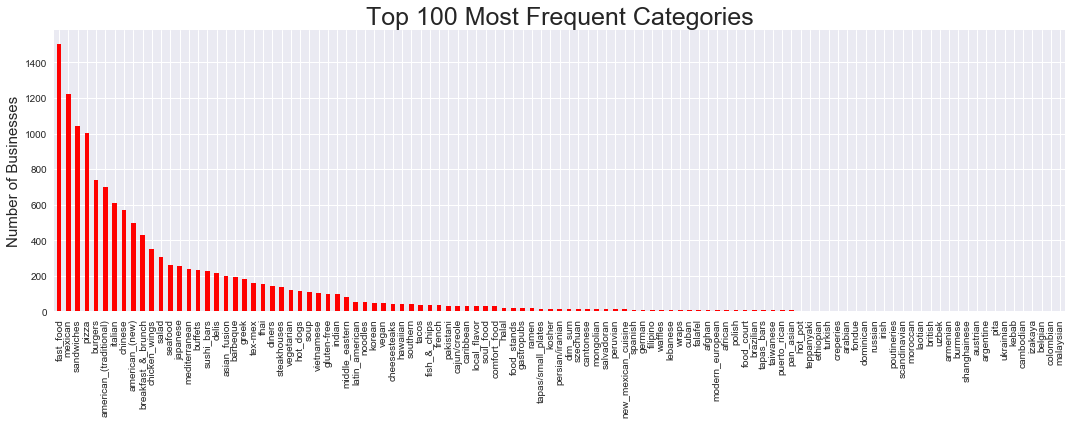

In [18]:
ax = df.plot(kind='bar',figsize=FIG_SIZE, color='r')
ax.set_title('Top 100 Most Frequent Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/restaurant_categories_all.png')
plt.show()
plt.close()

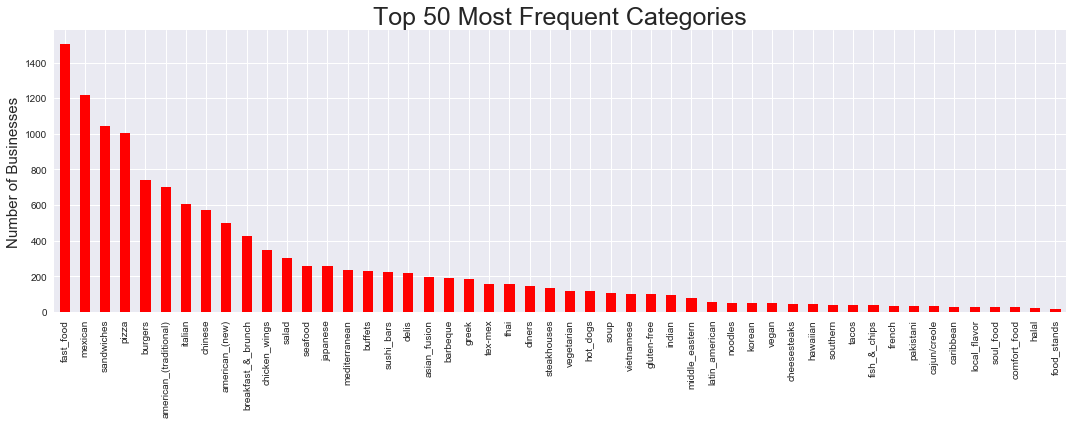

In [19]:
ax = df[:50].plot(kind='bar',figsize=FIG_SIZE, color='r')
ax.set_title('Top 50 Most Frequent Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/restaurant_categories_top_50.png')
plt.show()
plt.close()

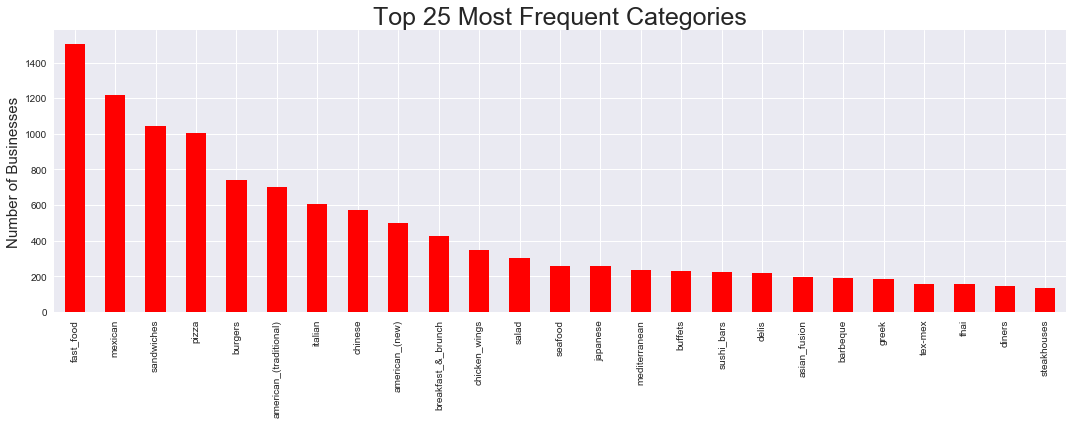

In [20]:
ax = df[:25].plot(kind='bar',figsize=FIG_SIZE, color='r')
ax.set_title('Top 25 Most Frequent Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/restaurant_categories_top_25.png')
plt.show()
plt.close()

# What if we ignore Fast Food?

Non Fast Food Restaurants 5561


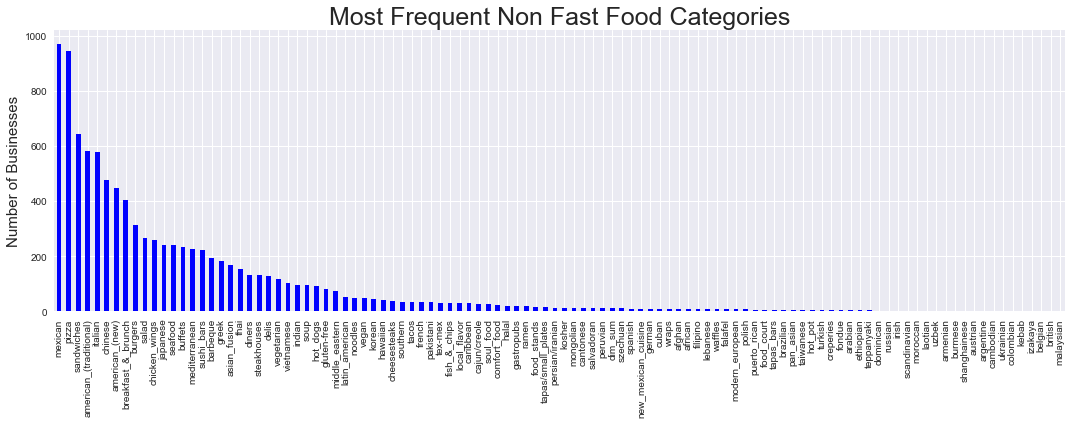

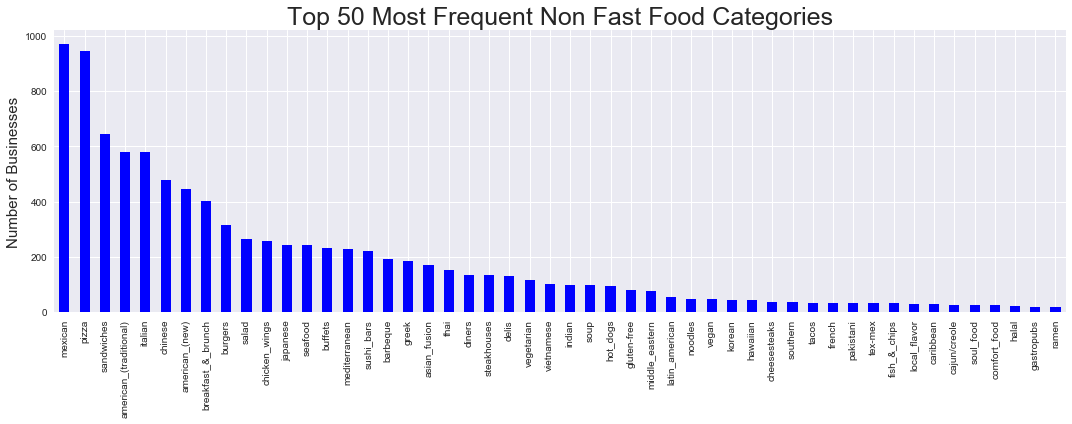

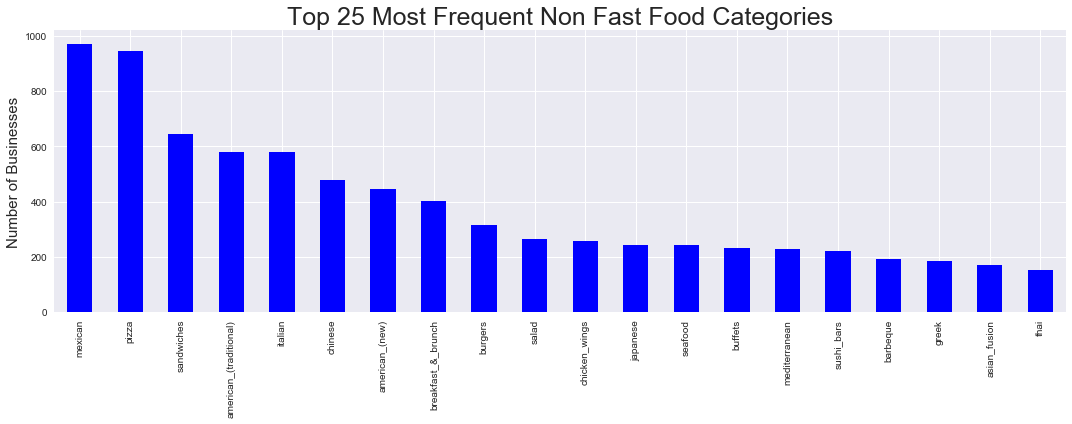

In [21]:
non_fast_food_restaurants = restaurant_df[restaurant_df.categories.apply(lambda x: 'fast_food' not in x)].copy()
print('Non Fast Food Restaurants {:d}'.format(non_fast_food_restaurants.shape[0]))

all_categories = list(itertools.chain.from_iterable(non_fast_food_restaurants.categories.values))

categories = {}

for item in all_categories:
    if item not in categories.keys():
        categories[item] = 1
    else:
        categories[item] += 1
del categories['restaurants']

df = pd.DataFrame.from_dict(categories, orient='index')
df.columns = ['counts']
df.sort_values('counts', inplace=True, ascending=False)

ax = df.plot(kind='bar',figsize=FIG_SIZE, color='b')
ax.set_title('Most Frequent Non Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/non_fast_food_restaurant_categories_all.png')
plt.show()
plt.close()


ax = df[:50].plot(kind='bar',figsize=FIG_SIZE, color='b')
ax.set_title('Top 50 Most Frequent Non Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/non_fast_food_restaurant_categories_top_50.png')
plt.show()
plt.close()

ax = df[:20].plot(kind='bar',figsize=FIG_SIZE, color='b')
ax.set_title('Top 25 Most Frequent Non Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/non_fast_food_restaurant_categories_top_25.png')
plt.show()
plt.close()

# What if we look at ONLY Fast Food?

Fast Food Restaurants 1505


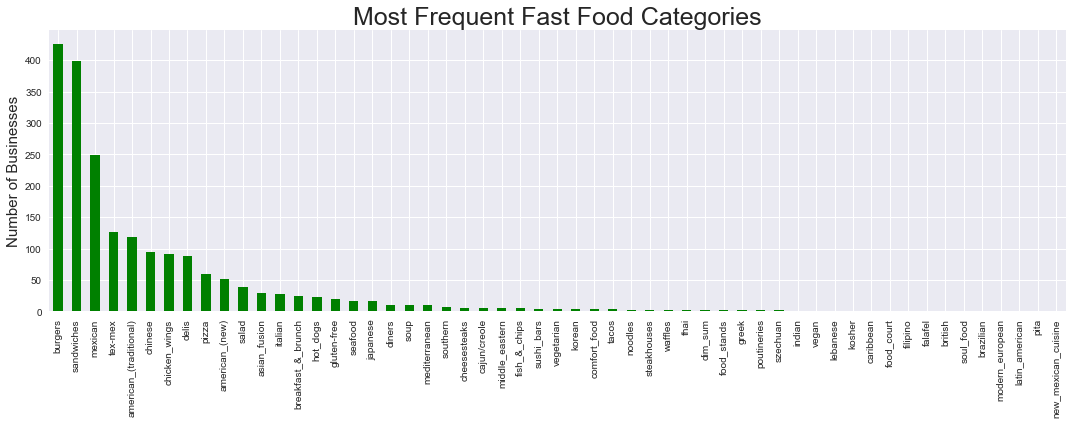

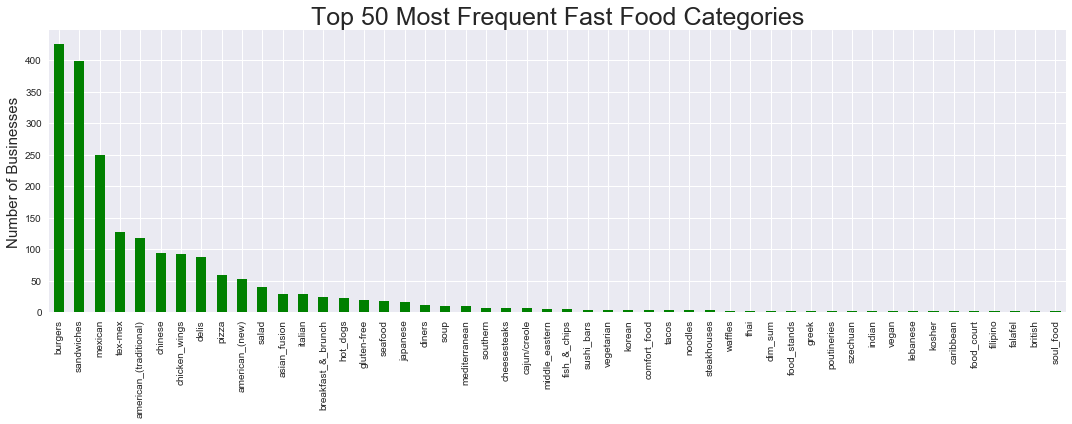

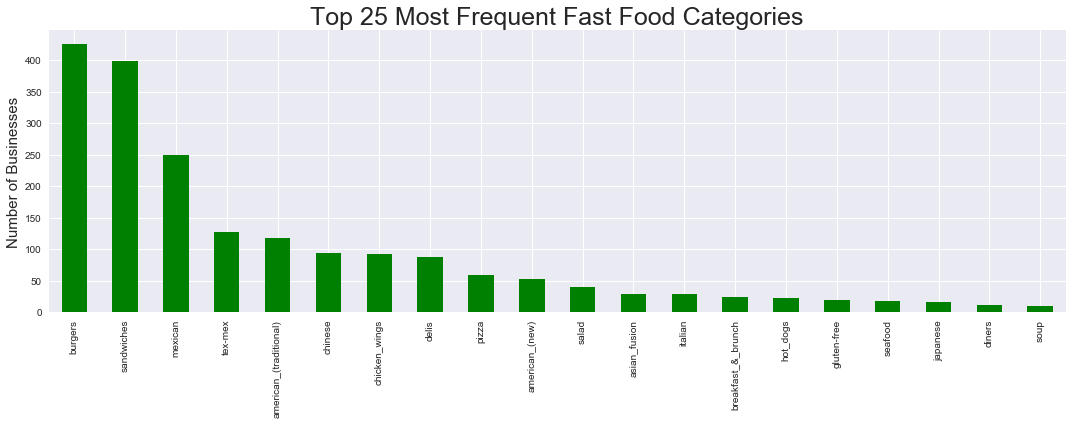

In [22]:
fast_food_restaurants = restaurant_df[restaurant_df.categories.apply(lambda x: 'fast_food' in x)].copy()
print('Fast Food Restaurants {:d}'.format(fast_food_restaurants.shape[0]))

all_categories = list(itertools.chain.from_iterable(fast_food_restaurants.categories.values))

categories = {}

for item in all_categories:
    if item not in categories.keys():
        categories[item] = 1
    else:
        categories[item] += 1
del categories['restaurants']
del categories['fast_food']

df = pd.DataFrame.from_dict(categories, orient='index')
df.columns = ['counts']
df.sort_values('counts', inplace=True, ascending=False)

ax = df.plot(kind='bar',figsize=FIG_SIZE, color='g')
ax.set_title('Most Frequent Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/fast_food_restaurant_categories_all.png')
plt.show()
plt.close()


ax = df[:50].plot(kind='bar',figsize=FIG_SIZE, color='g')
ax.set_title('Top 50 Most Frequent Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/fast_food_restaurant_categories_top_50.png')
plt.show()
plt.close()

ax = df[:20].plot(kind='bar',figsize=FIG_SIZE, color='g')
ax.set_title('Top 25 Most Frequent Fast Food Categories', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/fast_food_restaurant_categories_top_25.png')
plt.show()
plt.close()

# Write to File

In [23]:
file_name = '../clean_data/az_restaurant_business_clean.csv'
time_marker(text='Writing {:d} records to file {}'.format(restaurant_df.shape[0], file_name))
restaurant_df.to_csv(file_name, encoding='utf-8')

file_name = '../clean_data/az_restaurant_non_fast_food_business_clean.csv'
time_marker(text='Writing {:d} records to file {}'.format(non_fast_food_restaurants.shape[0], file_name))
non_fast_food_restaurants.to_csv(file_name, encoding='utf-8')

file_name = '../clean_data/az_restaurant_fast_food_business_clean.csv'
time_marker(text='Writing {:d} records to file {}'.format(fast_food_restaurants.shape[0], file_name))
fast_food_restaurants.to_csv(file_name, encoding='utf-8')

time_marker('done!')

[22:10:00.084898] writing 7066 records to file ../clean_data/az_restaurant_business_clean.csv
[22:10:00.207434] writing 5561 records to file ../clean_data/az_restaurant_non_fast_food_business_clean.csv
[22:10:00.288517] writing 1505 records to file ../clean_data/az_restaurant_fast_food_business_clean.csv
[22:10:00.319032] done!


In [24]:
restaurant_df.head()

,address,business_id,categories,city,is_open,name,neighborhood,postal_code,review_count,stars
0,719 E Thunderbird Rd,rDMptJYWtnMhpQu_rRXHng,"[fast_food, burgers, restaurants]",Phoenix,1,McDonald's,,85022,10,1.0
1,"777 E Thunderbird Rd, Ste 107",1WBkAuQg81kokZIPMpn9Zg,"[burgers, restaurants]",Phoenix,1,Charr An American Burger Bar,,85022,232,3.0
2,1635 E Camelback Rd,iPa__LOhse-hobC2Xmp-Kw,"[restaurants, burgers, fast_food]",Phoenix,1,McDonald's,,85016,34,3.0
3,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"[restaurants, pizza]",Mesa,1,Little Caesars Pizza,,85209,4,2.5
4,"8140 N Hayden Rd, Ste H115",VdlPZg2NAu8t8GkdbPLecg,"[restaurants, gluten-free, indian, seafood]",Scottsdale,1,Tandoori Times Indian Bistro,,85258,263,3.5


In [25]:
non_fast_food_restaurants.head()

,address,business_id,categories,city,is_open,name,neighborhood,postal_code,review_count,stars
1,"777 E Thunderbird Rd, Ste 107",1WBkAuQg81kokZIPMpn9Zg,"[burgers, restaurants]",Phoenix,1,Charr An American Burger Bar,,85022,232,3.0
3,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"[restaurants, pizza]",Mesa,1,Little Caesars Pizza,,85209,4,2.5
4,"8140 N Hayden Rd, Ste H115",VdlPZg2NAu8t8GkdbPLecg,"[restaurants, gluten-free, indian, seafood]",Scottsdale,1,Tandoori Times Indian Bistro,,85258,263,3.5
5,2810 North 75th Ave,QkG3KUXwqZBW18A9k1xqCA,"[american_(traditional), restaurants, seafood]",Phoenix,1,Red Lobster,,85035,37,2.5
6,1455 W Elliot Rd,nigYwB_m1TQ1WosjSWi-Hw,"[burgers, restaurants]",Gilbert,0,Simply Burgers,,85233,5,3.0


In [26]:
fast_food_restaurants.head()

,address,business_id,categories,city,is_open,name,neighborhood,postal_code,review_count,stars
0,719 E Thunderbird Rd,rDMptJYWtnMhpQu_rRXHng,"[fast_food, burgers, restaurants]",Phoenix,1,McDonald's,,85022,10,1.0
2,1635 E Camelback Rd,iPa__LOhse-hobC2Xmp-Kw,"[restaurants, burgers, fast_food]",Phoenix,1,McDonald's,,85016,34,3.0
7,3441 W Northern Ave,2v-8QQfMLX2PCz-0S6gISQ,"[pizza, restaurants, fast_food]",Phoenix,1,Papa John's Pizza,,85051,7,2.5
19,1483 N Dysart Rd,mfQlXkeNhW1vz_1iq63mNQ,"[restaurants, fast_food, mexican]",Avondale,1,Del Taco,,85323,23,2.5
21,17032 N 99th Ave,6CpAWkTcqqNtGAfOsPeFUw,"[american_(traditional), restaurants, sandwich...",Sun City,1,Arby's,,85373,9,3.5


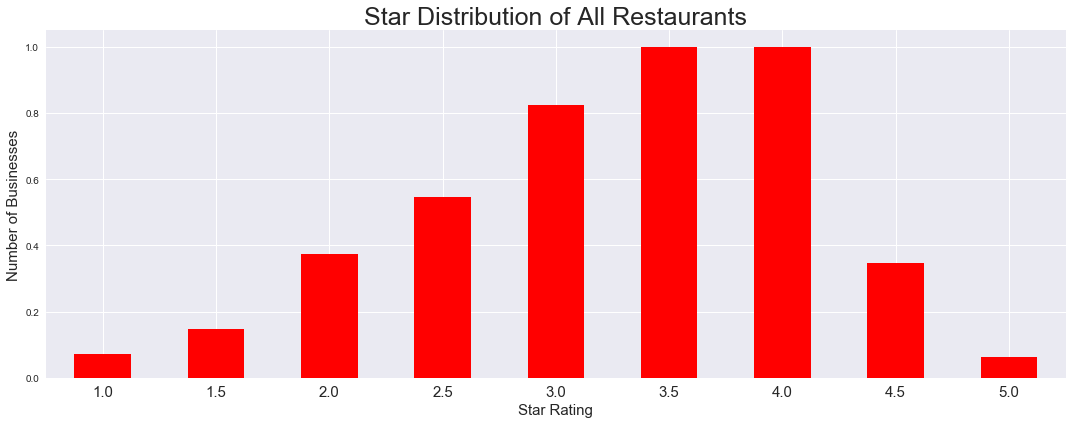

In [27]:
df = restaurant_df.groupby('stars').count()['business_id'].copy()
df = df/df.max()

ax = df.plot(kind='bar', figsize=FIG_SIZE, color='r')
ax.set_title('Star Distribution of All Restaurants', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.set_xlabel('Star Rating', size=LABEL_FONT_SIZE)
ax.set_xticklabels(df.index.values, size=TICK_FONT_SIZE, rotation=0)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/restaurant_star_distribution.png')
plt.show()
plt.close()

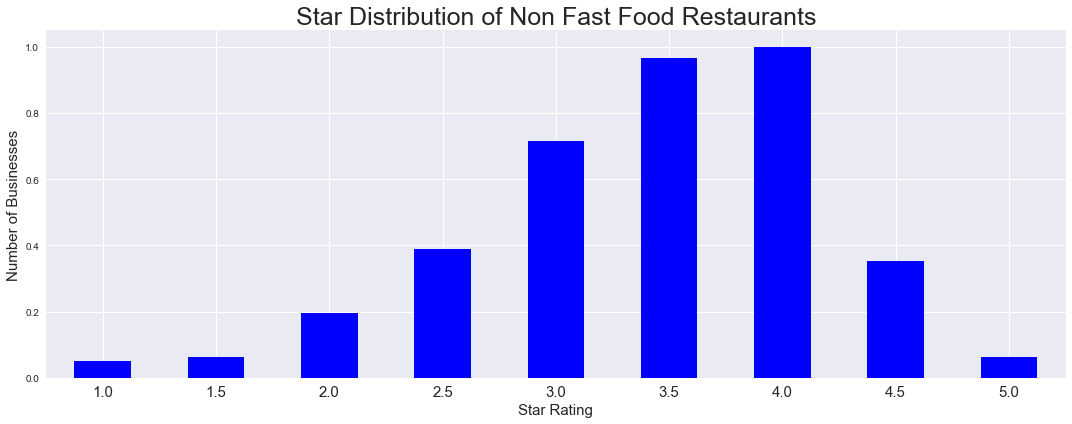

In [28]:
df = non_fast_food_restaurants.groupby('stars').count()['business_id'].copy()
df = df/df.max()
ax = df.plot(kind='bar', figsize=FIG_SIZE, color='b')

ax.set_title('Star Distribution of Non Fast Food Restaurants', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.set_xlabel('Star Rating', size=LABEL_FONT_SIZE)
ax.set_xlabel('Star Rating', size=LABEL_FONT_SIZE)
ax.set_xticklabels(df.index.values, size=TICK_FONT_SIZE, rotation=0)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/non_fast_food_restaurant_star_distribution.png')
plt.show()
plt.close()

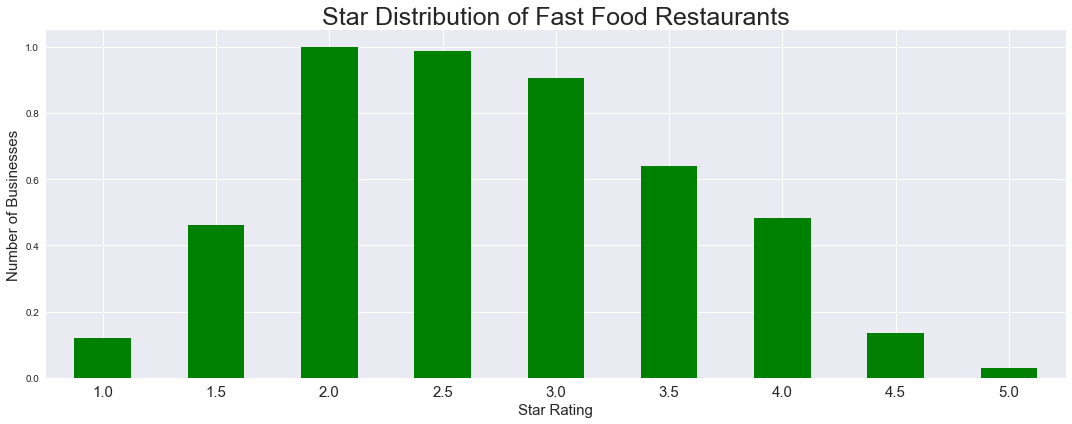

In [29]:
df = fast_food_restaurants.groupby('stars').count()['business_id'].copy()
df = df/df.max()
ax = df.plot(kind='bar', figsize=FIG_SIZE, color='g')

ax.set_title('Star Distribution of Fast Food Restaurants', size=TITLE_FONT_SIZE)
ax.set_ylabel('Number of Businesses', size=LABEL_FONT_SIZE)
ax.set_xlabel('Star Rating', size=LABEL_FONT_SIZE)
ax.set_xlabel('Star Rating', size=LABEL_FONT_SIZE)
ax.set_xticklabels(df.index.values, size=TICK_FONT_SIZE, rotation=0)
ax.legend('')
plt.tight_layout()
plt.savefig('../charts/fast_food_restaurant_star_distribution.png')
plt.show()
plt.close()